In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.parquet as pq
import pandas as pd
pd.options.display.max_rows = 100
from rich import print
import warnings
import datetime
from astropy.time import Time
import os
import astropy.units as u
from astroquery.gaia import Gaia
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
import time
from gfcat_utils import parse_lightcurves_csv,parse_exposure_time

In [49]:
def angularSeparation(ra1, dec1, ra2, dec2):
    d2r = np.pi/180.
    ra2deg = 1./d2r
    d1 = dec1*d2r,
    d2 = dec2*d2r
    r1 = ra1*d2r
    r2 = ra2*d2r
    a = np.sin((d2-d1)/2.)**2.+np.cos(d1)*np.cos(d2)*np.sin((r2-r1)/2.)**2.
    r = 2*np.arcsin(np.sqrt(a))
    return r*ra2deg

def counts2flux(cps, band):
    scale = 1.4e-15 if band == 'FUV' else 2.06e-16
    return scale*cps

def counts2mag(cps, band):
    scale = 18.82 if band == 'FUV' else 20.08
    # This threw a warning if the countrate was negative which happens when
    #  the background is brighter than the source. Suppress.
    with np.errstate(invalid='ignore'):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mag = -2.5 * np.log10(cps) + scale
    return mag

def mag2counts(mag, band):
    scale = 18.82 if band == 'FUV' else 20.08
    return 10.**(-(mag-scale)/2.5)

def apcorrect1(radius, band):
    if not band in ['NUV', 'FUV']:
        print("Invalid band.")
        return
    aper = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3, 30., 60., 90.])/3600.
    if radius > aper[-1]:
        return 0.
    if band == 'FUV':
        dmag = [1.65, 0.96, 0.36, 0.15, 0.1, 0.09, 0.07, 0.06, 0.03, 0.01]
    else:
        dmag = [2.09, 1.33, 0.59, 0.23, 0.13, 0.09, 0.07, 0.04, -0.00, -0.01]
        if radius > aper[-2]:
            return 0.
    if radius < aper[0]:
        return dmag[0]
    ix = np.where((aper-radius) >= 0.)
    x = [aper[ix[0][0]-1], aper[ix[0][0]]]
    y = [dmag[ix[0][0]-1], dmag[ix[0][0]]]
    m, C = np.polyfit(x, y, 1)
    return m*radius+C

In [65]:
tbl = pd.read_csv('gfcat_visit_table_crossmatched.csv',index_col=None)
print(tbl.keys())
tbl

Index(['eclipse', 'obj_id', 'ra', 'dec', 'morphology', 'simbad_n_match',
       'simbad_otype', 'simbad_main_id', 'simbad_distance',
       'simbad_match_offset', 'obstart', 'datetime_iso', 'datetime_decimal',
       'gaia_source_id', 'gaia_distance_uncorrected', 'gaia_distance', 'pmra',
       'pmdec', 'gaia_ra', 'gaia_dec', 'gaia_match_offset',
       'gaia_match_offset_uncorrected', 'gaia_n_match', 'distance'],
      dtype='object')

,eclipse,obj_id,ra,dec,morphology,simbad_n_match,simbad_otype,simbad_main_id,simbad_distance,simbad_match_offset,...,gaia_distance_uncorrected,gaia_distance,pmra,pmdec,gaia_ra,gaia_dec,gaia_match_offset,gaia_match_offset_uncorrected,gaia_n_match,distance
0,927,3715900927,249.909813,41.112522,U,1,RRLyrae,V* AF Her,3149.6062992125985,2.2239209651969762,...,3149.9248551741152,3149.9248551741152,-15.087261119357114,-8.080175499832446,249.908966309676,41.11272134880339,2.406354385486272,2.406354385486272,1,3149.606299
1,1413,1953301413,311.565113,-4.930670,F,1,Low-Mass*,2MASS J20461427-0456025,817.8621084485156,23.58975724917362,...,191.5361679559564,191.5361679559564,17.775261159394173,-33.68843862266971,311.56460295652903,-4.9303234507090945,2.2159375336534373,2.2159375336534373,2,191.536168
2,1420,1468701420,315.935391,-7.379244,F,1,Low-Mass*,2MASS J21034437-0722434,484.8719937936385,0.7203244462531776,...,950.886176042515,950.886176042515,6.000984483898851,-3.747006587605937,315.93490343193065,-7.37874171594827,2.5109036415987047,2.5109036415987047,2,484.871994
3,1422,1479501422,343.352654,-39.793072,F,1,Galaxy,LEDA 2794348,--,31.206438874927272,...,104.51288371426276,104.51288371426276,65.34788704439512,-49.015882825519924,343.3524180863038,-39.79298390977088,0.7256147124933267,0.7256147124933267,1,104.512884
4,1534,1091701534,259.445075,59.689607,F,1,Star,2MASS J17174656+5941240,129.1522446660123,2.3970117655300758,...,129.15169488954407,129.15169488954407,17.298796408388082,-14.592697130669343,259.4442121002186,59.68996728735478,2.035130085150521,2.035130085150521,2,129.151695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1376,45730,1513045730,27.571128,31.047408,F,0,--,--,--,--,...,149.45541490735877,149.45541490735877,28.050903236376325,-33.9470770471398,27.57067841820814,31.047595414459007,1.5412395193140607,1.5412395193140607,1,149.455415
1377,45856,1995745856,354.573904,-41.518851,F,1,Eruptive*,CD-42 16413,20.718818695833235,5.434909623343936,...,20.718816248924465,20.718816248924465,207.05925547231004,-202.96210326155446,354.57380380776203,-41.51861812150143,0.8804942080324154,0.8804942080324154,1,20.718816
1378,46287,637246287,35.457369,74.264867,F,0,--,--,--,--,...,120.09079129390042,120.09079129390042,36.570016611293504,-35.06420917340953,35.45534325661279,74.2651978884522,2.3077141236018313,2.3077141236018313,1,120.090791
1379,46523,1670546523,73.918598,-19.299443,F,1,HighPM*,PM J04556-1917,56.98297918411771,2.9469306805602704,...,56.98297282344062,56.98297282344062,21.369933184723397,-60.781327551286694,73.91824569068696,-19.299015690442456,1.9502301969131146,1.9502301969131146,2,56.982973


In [50]:
# e37477 has two variables, so use that as a tester

In [223]:
for i in np.arange(len(tbl)):
    visit = tbl.iloc[i]
    e = visit['eclipse']
    edir = str(e).zfill(5)
    epath = f"../data/lightcurves/e{edir}"
    ra,dec = visit['ra'],visit['dec']
    obs = {}
    for band in ['NUV','FUV']:
        fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
        try:
            expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
            lcs = parse_lightcurves_csv(fn)
            # a few eclipse have multiple variables, so we have to pick the right one
            ix = np.argmin(angularSeparation(ra,dec,
                           np.array([lc['ra'] for lc in lcs]),
                           np.array([lc['dec'] for lc in lcs])))
            lc = lcs[ix]
        except FileNotFoundError:
            continue
        obs[band] = [lc,expt]
        # observation minimum flux
        ix = np.where(lc['cps']==np.nanmin(lc['cps'][np.where(lc['cps']!=0)][:-1]))
        tbl.loc[i,f'mag_max_{band}']=counts2mag(lc['cps'][ix],band)
        tbl.loc[i,f'mag_max_err_{band}']=np.abs(
            counts2mag(lc['cps_err'][ix]+lc['cps'][ix],band)-counts2mag(lc['cps'][ix],band))
        
        # observation maximum flux
        ix = np.where(lc['cps']==np.nanmax(lc['cps'][np.where(np.isfinite(lc['cps']))][:-1]))
        tbl.loc[i,f'mag_min_{band}']=counts2mag(lc['cps'][ix],band)
        tbl.loc[i,f'mag_min_err_{band}']=np.abs(
            counts2mag(lc['cps_err'][ix]+lc['cps'][ix],band)-counts2mag(lc['cps'][ix],band))

        t = np.array(expt['expt_eff'])[np.where(np.isfinite(lc['cps']) & (lc['cps']!=0))][:-1]
        c = lc['cps'][np.where(np.isfinite(lc['cps']) & (lc['cps']!=0))][:-1]
        tbl.loc[i,f'mag_mean_{band}']=counts2mag((c*t).sum()/t.sum(),band)
        tbl.loc[i,f'mag_mean_err_{band}']=np.abs(
            counts2mag(np.sqrt((c*t).sum())/t.sum()+(c*t).sum()/t.sum(),band)-counts2mag((c*t).sum()/t.sum(),band))

        
        # add valid data start time, stop time, duration
        ix = np.where(np.isfinite(lc['cps']))
        tbl.loc[i,f'tstart_{band}'] = np.round(np.min(np.array(expt['t0'])[ix]))
        tbl.loc[i,f'tstop_{band}'] = np.round(np.max(np.array(expt['t0'])[ix]))
        tbl.loc[i,f'rawexpt_{band}'] = (np.round(np.max(np.array(expt['t0'])[ix])) -
                                        np.round(np.min(np.array(expt['t0'])[ix])))

    # if there is data for both bands, add the color information
    if len(obs.keys())==2:
        _,ix,_ = np.intersect1d(obs['NUV'][1]['t0'],obs['FUV'][1]['t0'],return_indices=True)
        color = (counts2flux(obs['FUV'][0]['cps'],'FUV')[ix][:-1] /
                 counts2flux(obs['NUV'][0]['cps'],'NUV')[ix][:-1])
        color_err = color * np.sqrt(
            (counts2flux(obs['NUV'][0]['cps_err'],'NUV')[ix][:-1] /
             counts2flux(obs['NUV'][0]['cps'],    'NUV')[ix][:-1])**2 +
            (counts2flux(obs['FUV'][0]['cps_err'],'FUV')[ix][:-1] /
             counts2flux(obs['FUV'][0]['cps'],    'FUV')[ix][:-1])**2)
        expt = obs['FUV'][1]
        ix = np.where(color==np.nanmin(color[np.where(color!=0)]))
        tbl.loc[i,'ratio_min'] = color[ix]
        tbl.loc[i,'ratio_min_err'] = color_err[ix]
        ix = np.where(color==np.nanmax(color[np.where(np.isfinite(color))]))
        tbl.loc[i,'ratio_max'] = color[ix]
        tbl.loc[i,'ratio_max_err'] = color_err[ix]
        ix = np.where(lc['cps']==np.nanmax(lc['cps'][np.where(np.isfinite(color))]))
        tbl.loc[i,'ratio_at_nuv_max'] = color[ix]
        tbl.loc[i,'ratio_at_nuv_max_err'] = color_err[ix]

        

tbl.to_csv('gfcat_visit_table_lcstats.csv',index=None)

In [ ]:
# make final QA plots
for i in np.arange(len(tbl)):
    visit = tbl.iloc[i]
    e = visit['eclipse']
    edir = str(e).zfill(5)
    epath = f"../data/lightcurves/e{edir}"
    ra,dec = visit['ra'],visit['dec']
    obs = {}
    for band in ['NUV','FUV']:
        fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
        try:
            expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
            lcs = parse_lightcurves_csv(fn)
            # a few eclipse have multiple variables, so we have to pick the right one
            ix = np.argmin(angularSeparation(ra,dec,
                           np.array([lc['ra'] for lc in lcs]),
                           np.array([lc['dec'] for lc in lcs])))
            lc = lcs[ix]
        except FileNotFoundError:
            continue
    
    if len(obs.keys())==1: # only a single band is present
        gs = gridspec.GridSpec(ncols=10,nrows=7)
        fig = plt.figure(figsize=(10,7));
    else:
        gs = gridspec.GridSpec(ncols=10,nrows=16)
        fig = plt.figure(figsize=(10,16));
    fig.tight_layout()
    ax = fig.add_subplot(gs[:5,:5])

    continue # skip plots for now
    for band in obs.keys():
        lc = obs[band][0]
        expt = obs[band][1]
        color = 'r' if band=='NUV' else 'b'
        plt.errorbar(expt['t0'],counts2flux(lc['cps'],band),
                     yerr=3*counts2flux(lc['cps_err'],band),fmt=f'{color}-',label=band)
    plt.yticks([])
    plt.xticks([])
    plt.legend();
    #plt.close('all')
    if not len(obs.keys())==2:
        continue
    lc_n = obs['NUV'][0]
    expt_n = obs['NUV'][1]
    lc_f = obs['FUV'][0]
    expt_f = obs['FUV'][1]
    plt.figure(figsize=(12,2))
    plt.title('color')
    err_color = np.sqrt(counts2flux(lc_f['cps_err'],'FUV')**2 + 
                        counts2flux(lc_n['cps_err']**2,'BAND'))
    plt.errorbar(expt_n['t0'],counts2flux(lc_f['cps'],'FUV')/counts2flux(lc_n['cps'],'NUV'),
                 #yerr=3*0,
                 fmt='k-')

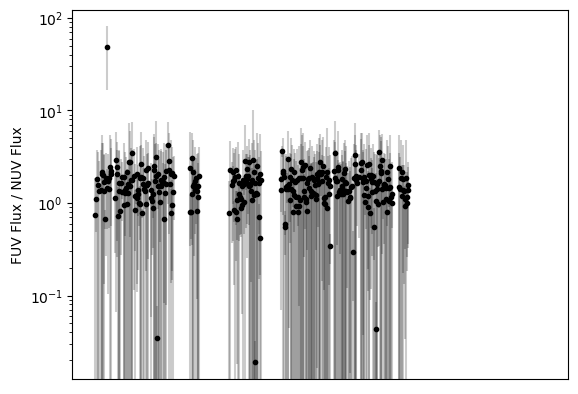

In [151]:
plt.errorbar(np.arange(len(tbl.loc[tbl['morphology']=='F'])),
             tbl.loc[tbl['morphology']=='F']['ratio_max'],
             yerr=3*tbl.loc[tbl['morphology']=='F']['ratio_max_err'],
             fmt='k.',alpha=0.2)
plt.errorbar(np.arange(len(tbl.loc[tbl['morphology']=='F'])),
             tbl.loc[tbl['morphology']=='F']['ratio_max'],
             fmt='k.',alpha=1)

plt.xticks([])
plt.ylabel('FUV Flux / NUV Flux')
plt.semilogy();

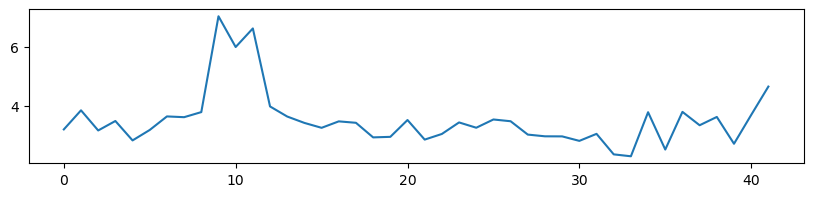

In [225]:
plt.figure(figsize=(10,2));
plt.plot(lc['cps'])

566    SB*
Name: simbad_otype, dtype: object

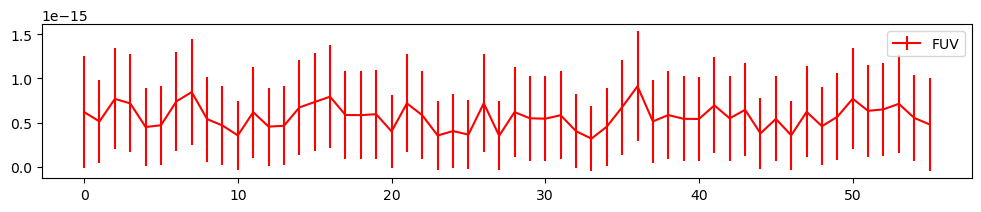

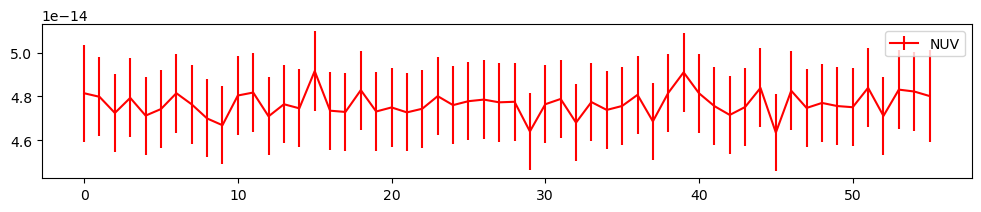

In [180]:
e = 15112
edir = str(e).zfill(5)
epath = f"../data/lightcurves/e{edir}"
ra,dec = visit['ra'],visit['dec']
obs = {}
for band in ['NUV','FUV']:
    fn = f"{epath}/e{edir}-{band[0].lower()}d-30s-photom-17_5.csv"
    expt = parse_exposure_time(f"{epath}/e{edir}-{band[0].lower()}d-30s-exptime.csv")
    lcs = parse_lightcurves_csv(fn)
    # a few eclipse have multiple variables, so we have to pick the right one
    ix = np.argmin(angularSeparation(ra,dec,
                   np.array([lc['ra'] for lc in lcs]),
                   np.array([lc['dec'] for lc in lcs])))
    lc = lcs[ix]
    obs[band] = [lc,expt]
plt.figure(figsize=(12,2))
plt.errorbar(np.arange(len(obs['FUV'][0]['cps'])),
         counts2flux(obs['FUV'][0]['cps'],'FUV'),
         yerr=3*counts2flux(obs['FUV'][0]['cps_err'],'FUV'),
         fmt='r',label="FUV")
plt.legend()
plt.figure(figsize=(12,2))
plt.errorbar(np.arange(len(obs['NUV'][0]['cps'])),
         counts2flux(obs['NUV'][0]['cps'],'NUV'),
         yerr=3*counts2flux(obs['NUV'][0]['cps_err'],'NUV'),
         fmt='r',label="NUV")
plt.legend()
print(tbl.loc[tbl['eclipse']==e]['simbad_otype'])

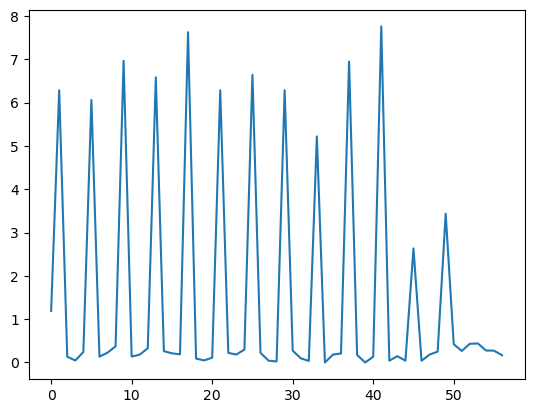

In [157]:
plt.figure(figsize=(12,2))
plt.plot(counts2flux(obs['FUV'][0]['cps'],'FUV'),'r',label="FUV")
plt.plot(counts2flux(obs['NUV'][0]['cps'],'NUV'),'r',label="NUV")
